# 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import scipy
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import os 
import glob
import cv2
import itertools

from dataloader_distance import *

# Bias 확인

In [12]:
def get_event_salted(file_path):
    
    df = pd.read_csv(file_path, skiprows=2)
    
    # 압력값 불러오기
    prs = df.filter(regex="R_value")
    prs_mean = np.mean(prs.iloc[:, 0:4], axis=1) 
    
    # Gaussian Filter : Smoothing pressure data
    prs_mean_gf = pd.Series(scipy.ndimage.gaussian_filter1d(prs_mean, 2))
    
    # Level Shift 
    lev_idx = prs_mean_gf > 2 # 가우시안 필터로 인해 0이 아닌 값으로 threshold 설정
    prs_lev = lev_idx.map(lambda x : 1 if x else 0)
    
    # HS, TO Index 추출
    event_idx = []
    for i in range(len(prs_lev)-1):
        if (prs_lev[i] - prs_lev[i+1]) != 0:
            event_idx.append(i)
            
    # HS 이벤트가 먼저 시작하도록 : 나중에 lev shift를 통해 구하는 방법으로 변경하는 것도 괜찮을 듯
    if np.diff(event_idx)[0] < np.diff(event_idx)[1]: # Swing Phase가 Stand Phase보다 길다는 것을 가정 : 장애 데이터에서도 확인 필요
        del event_idx[0]
    
    
    return event_idx

def get_sensor_salted(file_path, normalization=True):
    inputs_acc = []
    inputs_gyr = []
    stride_length = []
    for file_name in glob.glob(file_path):
        df = pd.read_csv(file_name, skiprows=2)
        acc = df.filter(regex="R_ACC")
        gyr = df.filter(regex="R_GYRO")
        event_idx = get_event_salted(file_name)

        # HS 이벤트 추출
        event_hs = event_idx[0::2]

        # m/s^2 단위 변환
        acc = (acc / 1000) * 9.8066
    #     acc_z = acc_z - np.mean(acc_z) # z축(상하)에 적용되는 중력가속도 제거 : 추가확인 필요
    
        # x축과 z축에 적용되는 bias 제거(z축의 경우 중력가속도)
        acc['R_ACC_X']= acc['R_ACC_X'] - np.mean(acc['R_ACC_X'])
        acc['R_ACC_Z']= acc['R_ACC_Z'] - np.mean(acc['R_ACC_Z']) 

        # Normalization
        if normalization == True:
            scaler = MinMaxScaler()
            acc_norm = scaler.fit_transform(acc)
            gyr_norm = scaler.fit_transform(gyr)

        # 가속도와 자이로 센서 값
        for i in range(1, len(event_hs)):
            if normalization == True:
                inputs_acc.append(np.transpose(cv2.resize(acc_norm[event_hs[i-1]:event_hs[i]], dsize=(3, 300))))
                inputs_gyr.append(np.transpose(cv2.resize(gyr_norm[event_hs[i-1]:event_hs[i]], dsize=(3, 300))))
            else:
                inputs_acc.append(np.transpose(acc[event_hs[i-1]:event_hs[i]]))
                inputs_gyr.append(np.transpose(gyr[event_hs[i-1]:event_hs[i]]))

    
        if '3km' in file_name:
            stride_length.append(np.diff(event_hs) * (3000/3600))
        elif '4km' in file_name:
            stride_length.append(np.diff(event_hs) * (4000/3600))
        else:
            stride_length.append(np.diff(event_hs) * (5000/3600))
            
    stride_length = np.round(np.array(list(itertools.chain.from_iterable(stride_length))), 3)
    
    return inputs_acc, inputs_gyr, stride_length



def get_axis_sensor_salted(file_path, normalization=True):
    inputs_x = []
    inputs_y = []
    inputs_z = []
    stride_length = []
    for file_name in glob.glob(file_path):
        df = pd.read_csv(file_name, skiprows=2)
        acc = df.filter(regex="R_ACC")
        gyr = df.filter(regex="R_GYRO")
        event_idx = get_event_salted(file_name)

        # HS 이벤트 추출
        event_hs = event_idx[0::2]

        # m/s^2 단위 변환
        acc = (acc / 1000) * 9.8066
    #     acc_z = acc_z - np.mean(acc_z) # z축(상하)에 적용되는 중력가속도 제거 : 추가확인 필요

        # Normalization
        if normalization == True:
            scaler = MinMaxScaler()
            acc_norm = scaler.fit_transform(acc)
            gyr_norm = scaler.fit_transform(gyr)

            
        # 가속도와 자이로 센서 값
        for i in range(1, len(event_hs)):
            if normalization == True:
                inputs_x.append(np.vstack([np.transpose(cv2.resize(acc_norm[:, 0][event_hs[i-1]:event_hs[i]], dsize=(1, 300))), 
                                           np.transpose(cv2.resize(gyr_norm[:, 0][event_hs[i-1]:event_hs[i]], dsize=(1, 300)))]))
                inputs_y.append(np.vstack([np.transpose(cv2.resize(acc_norm[:, 1][event_hs[i-1]:event_hs[i]], dsize=(1, 300))), 
                                           np.transpose(cv2.resize(gyr_norm[:, 1][event_hs[i-1]:event_hs[i]], dsize=(1, 300)))]))
                inputs_z.append(np.vstack([np.transpose(cv2.resize(acc_norm[:, 2][event_hs[i-1]:event_hs[i]], dsize=(1, 300))), 
                                           np.transpose(cv2.resize(gyr_norm[:, 2][event_hs[i-1]:event_hs[i]], dsize=(1, 300)))]))
            else:
                inputs_acc.append(np.transpose(acc[event_hs[i-1]:event_hs[i]]))
                inputs_gyr.append(np.transpose(gyr[event_hs[i-1]:event_hs[i]]))

    
        if '3km' in file_name:
            stride_length.append(np.diff(event_hs) * (3000/3600))
        elif '4km' in file_name:
            stride_length.append(np.diff(event_hs) * (4000/3600))
        else:
            stride_length.append(np.diff(event_hs) * (5000/3600))
            
    stride_length = np.round(np.array(list(itertools.chain.from_iterable(stride_length))), 3)
    
    return inputs_x, inputs_y, inputs_z, stride_length


def get_speed_salted(file_path):
    inputs_acc, _, _ = get_sensor_salted(file_path, normalization=False)
    inputs_spd = []
    for i in range(len(inputs_acc)):
        spd = pd.DataFrame(scipy.integrate.cumulative_trapezoid(inputs_acc[i], dx=(1/100)))
        inputs_spd.append(spd) #m/s
    return inputs_spd

def get_position_salted(file_path, distance=False):
    inputs_spd = get_speed_salted(file_path)
    inputs_pst = []
    for i in range(len(inputs_spd)):
        pst = pd.DataFrame(scipy.integrate.cumulative_trapezoid(inputs_spd[i], dx=(1/100)))
        if distance==True:
            pst = np.sum(pst, axis=1)
        inputs_pst.append(pst)
    return inputs_pst


In [13]:
file_path = "D:\gait_dataset/salted/train/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=False)
inputs_pst = get_position_salted(file_path, distance=True)

In [11]:
# bias

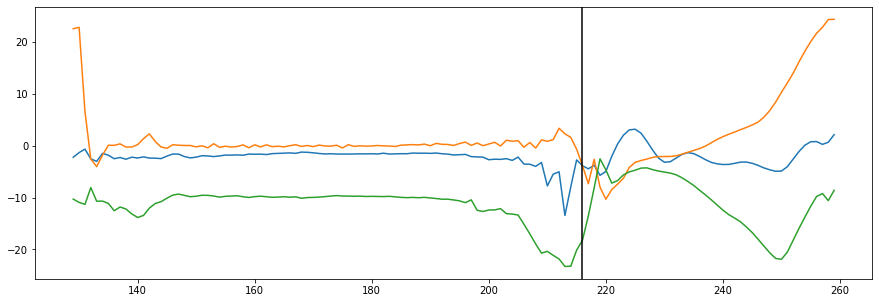

In [6]:
plt.figure(figsize=(15,5))
plt.plot(inputs_acc[0].transpose())
plt.axvline(x=216, color='k')
plt.show()

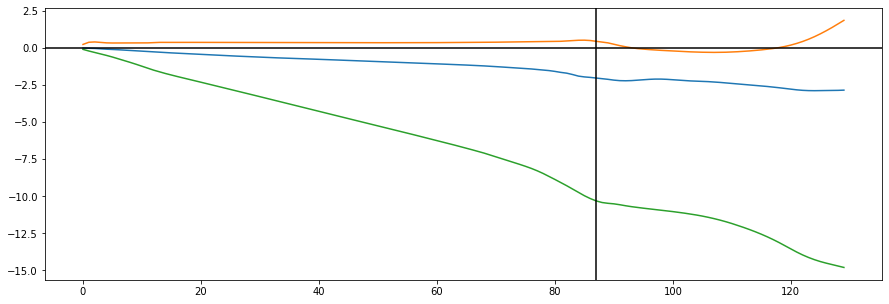

In [7]:
plt.figure(figsize=(15,5))
plt.plot(scipy.integrate.cumulative_trapezoid(inputs_acc[0], dx=(1/100)).transpose())
plt.axhline(y=0, color='k')
plt.axvline(x=87, color='k')
plt.show() 

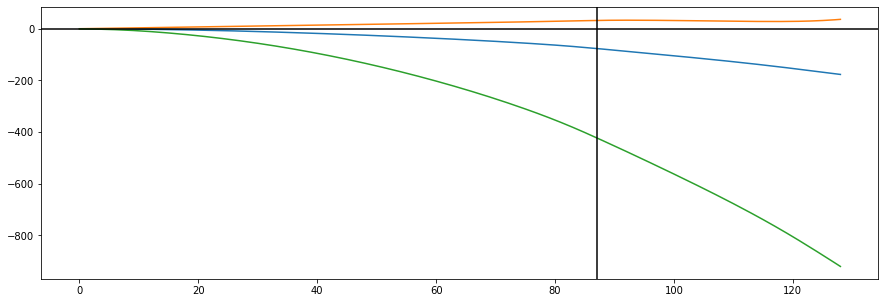

In [10]:
spd = scipy.integrate.cumulative_trapezoid(inputs_acc[0], dx=(1/100))

plt.figure(figsize=(15,5))
plt.plot(scipy.integrate.cumulative_trapezoid(spd, dx=(1/100)).transpose()*100)
plt.axhline(y=0, color='k')
plt.axvline(x=87, color='k')
plt.show()
pst = pd.DataFrame(scipy.integrate.cumulative_trapezoid(spd, dx=(1/100)).transpose()*100)

In [ ]:
# nobias

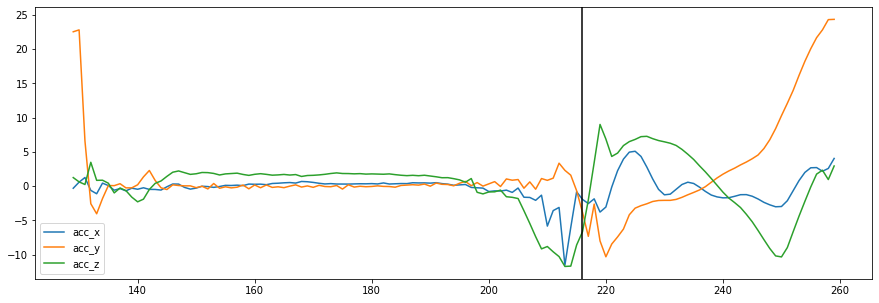

In [23]:
plt.figure(figsize=(15,5))
plt.plot(inputs_acc[0].transpose())
plt.axvline(x=216, color='k')
plt.legend(labels=['acc_x', 'acc_y', 'acc_z'])
plt.show()

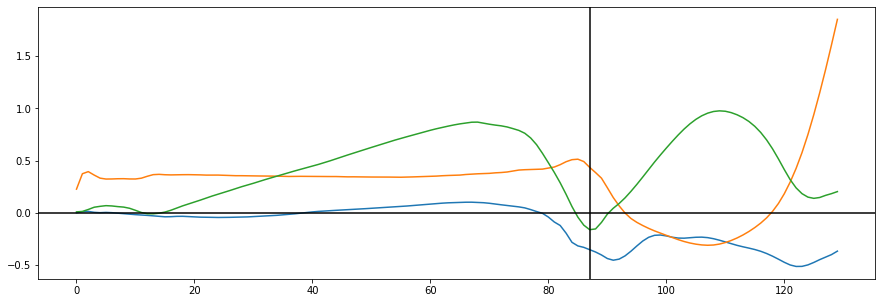

In [15]:
plt.figure(figsize=(15,5))
plt.plot(scipy.integrate.cumulative_trapezoid(inputs_acc[0], dx=(1/100)).transpose())
plt.axhline(y=0, color='k')
plt.axvline(x=87, color='k')
plt.show() 

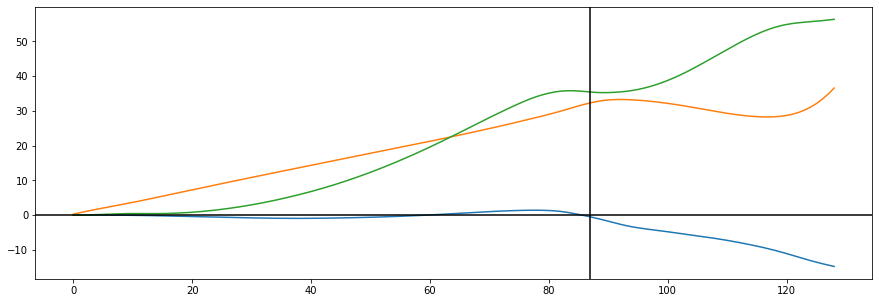

In [16]:
spd = scipy.integrate.cumulative_trapezoid(inputs_acc[0], dx=(1/100))

plt.figure(figsize=(15,5))
plt.plot(scipy.integrate.cumulative_trapezoid(spd, dx=(1/100)).transpose()*100)
plt.axhline(y=0, color='k')
plt.axvline(x=87, color='k')
plt.show()
pst = pd.DataFrame(scipy.integrate.cumulative_trapezoid(spd, dx=(1/100)).transpose()*100)

# Linear Regression : 전체 속도

## Bias
- MAE : 15.3458, Corr : 0.7342

In [21]:
file_path_train = "D:\gait_dataset/salted/train/*"
_, _, y_train = get_sensor_salted(file_path_train, bias=True)
inputs_pst_train = get_position_salted(file_path_train, distance=True, bias=True)

file_path_test = "D:\gait_dataset/salted/test/*"
_, _, y_test = get_sensor_salted(file_path_test, bias=True)
inputs_pst_test = get_position_salted(file_path_test, distance=True, bias=True)

In [22]:
x_train = pd.DataFrame(inputs_pst_train)
x_train.columns =  ['R_DIS_X', 'R_DIS_Y', 'R_DIS_Z']

x_test = pd.DataFrame(inputs_pst_test)
x_test.columns =  ['R_DIS_X', 'R_DIS_Y', 'R_DIS_Z']

In [23]:
x_train

,R_DIS_X,R_DIS_Y,R_DIS_Z
0,0.325056,0.295638,0.591209
1,0.408169,0.226372,0.594593
2,0.385037,0.185862,0.569153
3,0.432047,0.206133,0.605114
4,0.483833,0.175300,0.620395
...,...,...,...
3348,0.586512,0.318631,0.656599
3349,0.603322,0.399322,0.698904
3350,0.649342,0.543410,0.669275
3351,0.533692,0.235974,0.705292


In [24]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

In [25]:
MAE = mean_absolute_error(y_test, y_pred)
corr = np.corrcoef(y_test, y_pred)
print('MAE : {:.4f}, Corr : {:.4f}'.format(MAE, corr[0, 1]))

MAE : 15.3458, Corr : 0.7342


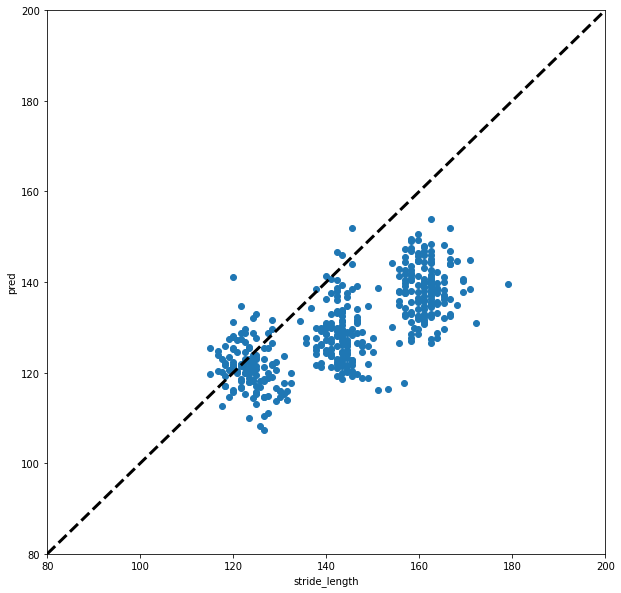

In [26]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

## No Bias
- MAE : 9.6073, Corr : 0.8433

In [27]:
file_path_train = "D:\gait_dataset/salted/train/*"
_, _, y_train = get_sensor_salted(file_path_train)
inputs_pst_train = get_position_salted(file_path_train, distance=True)

file_path_test = "D:\gait_dataset/salted/test/*"
_, _, y_test = get_sensor_salted(file_path_test)
inputs_pst_test = get_position_salted(file_path_test, distance=True)

In [28]:
x_train = pd.DataFrame(inputs_pst_train)
x_train.columns =  ['R_DIS_X', 'R_DIS_Y', 'R_DIS_Z']

x_test = pd.DataFrame(inputs_pst_test)
x_test.columns =  ['R_DIS_X', 'R_DIS_Y', 'R_DIS_Z']

In [29]:
x_train

,R_DIS_X,R_DIS_Y,R_DIS_Z
0,0.480722,0.295638,0.458039
1,0.586145,0.226372,0.356585
2,0.576720,0.185862,0.401143
3,0.608438,0.206133,0.318425
4,0.670155,0.175300,0.323131
...,...,...,...
3348,0.614802,0.318631,0.583109
3349,0.618855,0.399322,0.561479
3350,0.683577,0.543410,0.307011
3351,0.514616,0.235974,0.492303


In [30]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

In [31]:
MAE = mean_absolute_error(y_test, y_pred)
corr = np.corrcoef(y_test, y_pred)
print('MAE : {:.4f}, Corr : {:.4f}'.format(MAE, corr[0, 1]))

MAE : 9.6073, Corr : 0.8433


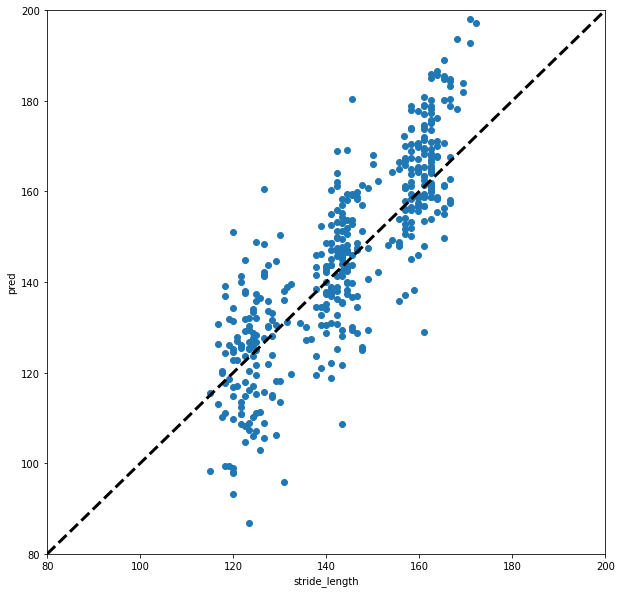

In [32]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

# Encoder-based Model : 최종 노드 1개

## No bias
- Best Result : Epoch 263, Valid Loss 13.012, MAE 2.211, Corr 0.981159

### 데이터 불러오기 

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Salted(file_path, bias=False)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [3]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

### Model & Scatter Plot
- 인코더에 Conv1d만을 사용
- 인코더의 아웃풋 길이가 늘어나 FC Layer의 수를 늘려 실험
    - FC Layer : enc_output -> 512 -> 256 -> 128 -> 64 -> 32 -> 1

In [7]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(7744*2, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        

    def forward(self, inputs_acc, inputs_gyr): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        enc_output = torch.concat((conv1d_output_acc, conv1d_output_gyr), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [8]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [9]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_corr = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, _ = data
        inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
        inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr)
        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()

        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, _ = data
            inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
            inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    corr = torch.corrcoef(torch.stack([torch.squeeze(stride_length), torch.squeeze(outputs)]))[0, 1]
    
    
    print("Epoch : {}/{}, Train Loss : {:.3f}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE, corr))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_corr = corr
        best_epoch = epoch+1
        torch.save(model.state_dict(), './model/encoder_1_best_ks30_nobias.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}'.format(best_epoch, best, best_MAE, best_corr))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 6786.579, Valid Loss 943.835, MAE 27.151, Corr 0.552050
Best Valid Loss 943.8347
Epoch : 2/2000, Train Loss : 617.510, Valid Loss 344.659, MAE 13.862, Corr 0.585996
Best Valid Loss 344.6592
Epoch : 3/2000, Train Loss : 271.541, Valid Loss 245.050, MAE 11.567, Corr 0.604921
Best Valid Loss 245.0502
Epoch : 4/2000, Train Loss : 237.525, Valid Loss 241.772, MAE 11.769, Corr 0.619340
Best Valid Loss 241.7715
Epoch : 5/2000, Train Loss : 239.398, Valid Loss 234.503, MAE 11.312, Corr 0.631786
Best Valid Loss 234.5031
Epoch : 6/2000, Train Loss : 230.314, Valid Loss 229.051, MAE 11.164, Corr 0.642385
Best Valid Loss 229.0513
Epoch : 7/2000, Train Loss : 226.553, Valid Loss 225.416, MAE 11.003, Corr 0.652619
Best Valid Loss 225.4157
Epoch : 8/2000, Train Loss : 223.154, Valid Loss 218.783, MAE 10.794, Corr 0.660576
Best Valid Loss 218.7832
Epoch : 9/2000, Train Loss : 219.644, Valid Loss 218.794, MAE 10.734, Corr 0.667483
Epoch : 10/2000, Train Loss : 221.228, Vali

Epoch : 89/2000, Train Loss : 21.657, Valid Loss 21.145, MAE 2.906, Corr 0.969578
Best Valid Loss 21.1452
Epoch : 90/2000, Train Loss : 23.280, Valid Loss 23.546, MAE 3.463, Corr 0.973764
Epoch : 91/2000, Train Loss : 25.264, Valid Loss 20.777, MAE 2.849, Corr 0.972763
Best Valid Loss 20.7770
Epoch : 92/2000, Train Loss : 31.461, Valid Loss 28.484, MAE 3.049, Corr 0.969107
Epoch : 93/2000, Train Loss : 27.904, Valid Loss 35.503, MAE 4.894, Corr 0.972656
Epoch : 94/2000, Train Loss : 39.686, Valid Loss 34.785, MAE 3.799, Corr 0.971392
Epoch : 95/2000, Train Loss : 36.476, Valid Loss 34.824, MAE 4.700, Corr 0.971079
Epoch : 96/2000, Train Loss : 24.191, Valid Loss 20.951, MAE 2.786, Corr 0.970879
Epoch : 97/2000, Train Loss : 23.572, Valid Loss 23.808, MAE 3.585, Corr 0.971699
Epoch : 98/2000, Train Loss : 25.863, Valid Loss 19.878, MAE 2.776, Corr 0.973990
Best Valid Loss 19.8784
Epoch : 99/2000, Train Loss : 32.522, Valid Loss 56.009, MAE 7.044, Corr 0.970403
Epoch : 100/2000, Train Lo

Epoch : 183/2000, Train Loss : 18.315, Valid Loss 16.079, MAE 2.677, Corr 0.979124
Epoch : 184/2000, Train Loss : 15.723, Valid Loss 15.241, MAE 2.454, Corr 0.981028
Best Valid Loss 15.2412
Epoch : 185/2000, Train Loss : 20.235, Valid Loss 15.556, MAE 2.341, Corr 0.980735
Epoch : 186/2000, Train Loss : 32.054, Valid Loss 20.298, MAE 2.877, Corr 0.977746
Epoch : 187/2000, Train Loss : 19.583, Valid Loss 23.396, MAE 4.030, Corr 0.979939
Epoch : 188/2000, Train Loss : 18.551, Valid Loss 15.332, MAE 2.561, Corr 0.979936
Epoch : 189/2000, Train Loss : 16.432, Valid Loss 14.872, MAE 2.389, Corr 0.981042
Best Valid Loss 14.8724
Epoch : 190/2000, Train Loss : 20.548, Valid Loss 15.253, MAE 2.344, Corr 0.980367
Epoch : 191/2000, Train Loss : 18.370, Valid Loss 21.322, MAE 3.713, Corr 0.979496
Epoch : 192/2000, Train Loss : 17.074, Valid Loss 14.692, MAE 2.235, Corr 0.981786
Best Valid Loss 14.6919
Epoch : 193/2000, Train Loss : 15.853, Valid Loss 17.210, MAE 2.995, Corr 0.981056
Epoch : 194/200

Epoch : 279/2000, Train Loss : 14.555, Valid Loss 14.229, MAE 2.424, Corr 0.977423
Epoch : 280/2000, Train Loss : 19.062, Valid Loss 72.379, MAE 8.251, Corr 0.979086
Epoch : 281/2000, Train Loss : 24.861, Valid Loss 16.315, MAE 2.769, Corr 0.977432
Epoch : 282/2000, Train Loss : 13.498, Valid Loss 17.961, MAE 2.951, Corr 0.979543
Epoch : 283/2000, Train Loss : 13.326, Valid Loss 14.194, MAE 2.613, Corr 0.980142
Epoch : 284/2000, Train Loss : 12.680, Valid Loss 32.580, MAE 5.248, Corr 0.981298
Early stopping
Best Result : Epoch 263, Valid Loss 13.012, MAE 2.211, Corr 0.981159


In [10]:
### scatter plot
file_path = "D:\gait_dataset/salted/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_acc, inputs_gyr, stride_length = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length))
inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)

In [11]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./model/encoder_1_best_ks30_nobias.pth'))
model.eval()

Encoder(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=15488, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

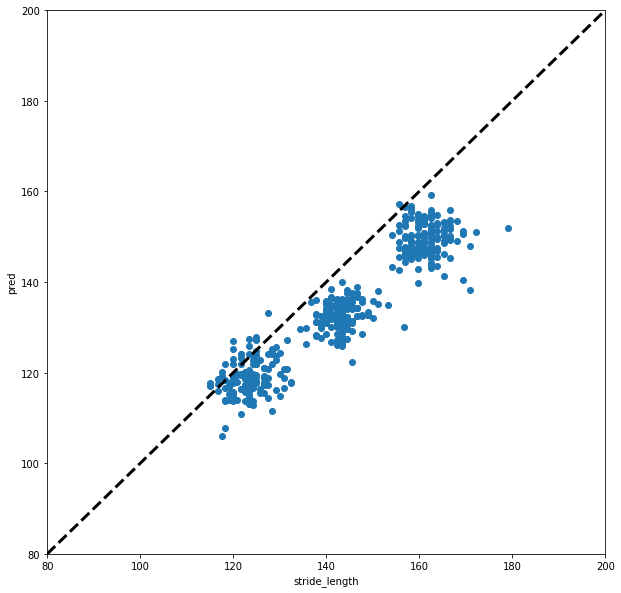

In [13]:
pred = model(inputs_acc, inputs_gyr).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

## Bias
- Best Result : Epoch 313, Valid Loss 10.596, MAE 2.744, Corr 0.976224

### 데이터 불러오기 

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Salted(file_path, bias=True)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [15]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

### Model & Scatter Plot
- 인코더에 Conv1d만을 사용
- 인코더의 아웃풋 길이가 늘어나 FC Layer의 수를 늘려 실험
    - FC Layer : enc_output -> 512 -> 256 -> 128 -> 64 -> 32 -> 1

In [16]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(7744*2, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        

    def forward(self, inputs_acc, inputs_gyr): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        enc_output = torch.concat((conv1d_output_acc, conv1d_output_gyr), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [17]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [18]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_corr = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, _ = data
        inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
        inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr)
        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()

        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, _ = data
            inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
            inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    corr = torch.corrcoef(torch.stack([torch.squeeze(stride_length), torch.squeeze(outputs)]))[0, 1]
    
    
    print("Epoch : {}/{}, Train Loss : {:.3f}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE, corr))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_corr = corr
        best_epoch = epoch+1
        torch.save(model.state_dict(), './model/encoder_1_best_ks30_bias.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}'.format(best_epoch, best, best_MAE, best_corr))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 6744.895, Valid Loss 783.600, MAE 27.136, Corr 0.023566
Best Valid Loss 783.6002
Epoch : 2/2000, Train Loss : 587.428, Valid Loss 352.932, MAE 12.824, Corr 0.064475
Best Valid Loss 352.9320
Epoch : 3/2000, Train Loss : 277.999, Valid Loss 253.815, MAE 11.697, Corr 0.087255
Best Valid Loss 253.8146
Epoch : 4/2000, Train Loss : 237.259, Valid Loss 251.216, MAE 11.707, Corr 0.104823
Best Valid Loss 251.2164
Epoch : 5/2000, Train Loss : 236.936, Valid Loss 241.139, MAE 11.785, Corr 0.120193
Best Valid Loss 241.1391
Epoch : 6/2000, Train Loss : 232.600, Valid Loss 232.550, MAE 12.672, Corr 0.133611
Best Valid Loss 232.5495
Epoch : 7/2000, Train Loss : 230.153, Valid Loss 275.914, MAE 11.903, Corr 0.146945
Epoch : 8/2000, Train Loss : 231.031, Valid Loss 231.505, MAE 12.859, Corr 0.159554
Best Valid Loss 231.5050
Epoch : 9/2000, Train Loss : 221.526, Valid Loss 226.479, MAE 11.948, Corr 0.175167
Best Valid Loss 226.4786
Epoch : 10/2000, Train Loss : 222.522, Vali

Epoch : 89/2000, Train Loss : 24.939, Valid Loss 26.155, MAE 3.712, Corr 0.957608
Epoch : 90/2000, Train Loss : 24.857, Valid Loss 38.222, MAE 5.400, Corr 0.957677
Epoch : 91/2000, Train Loss : 27.200, Valid Loss 49.159, MAE 6.440, Corr 0.959607
Epoch : 92/2000, Train Loss : 43.711, Valid Loss 64.878, MAE 5.952, Corr 0.950347
Epoch : 93/2000, Train Loss : 30.474, Valid Loss 25.670, MAE 3.469, Corr 0.958812
Best Valid Loss 25.6699
Epoch : 94/2000, Train Loss : 39.625, Valid Loss 48.122, MAE 6.163, Corr 0.946228
Epoch : 95/2000, Train Loss : 34.286, Valid Loss 36.172, MAE 5.120, Corr 0.956447
Epoch : 96/2000, Train Loss : 26.281, Valid Loss 30.288, MAE 4.491, Corr 0.957653
Epoch : 97/2000, Train Loss : 24.872, Valid Loss 32.143, MAE 4.685, Corr 0.957510
Epoch : 98/2000, Train Loss : 27.318, Valid Loss 39.347, MAE 4.230, Corr 0.957136
Epoch : 99/2000, Train Loss : 33.539, Valid Loss 25.561, MAE 3.487, Corr 0.959481
Best Valid Loss 25.5605
Epoch : 100/2000, Train Loss : 25.320, Valid Loss 

Epoch : 183/2000, Train Loss : 21.859, Valid Loss 37.264, MAE 4.220, Corr 0.967675
Epoch : 184/2000, Train Loss : 23.738, Valid Loss 16.722, MAE 3.167, Corr 0.966282
Best Valid Loss 16.7223
Epoch : 185/2000, Train Loss : 18.618, Valid Loss 16.151, MAE 2.941, Corr 0.967526
Best Valid Loss 16.1508
Epoch : 186/2000, Train Loss : 20.832, Valid Loss 23.660, MAE 3.588, Corr 0.969890
Epoch : 187/2000, Train Loss : 17.622, Valid Loss 19.616, MAE 3.362, Corr 0.967983
Epoch : 188/2000, Train Loss : 17.146, Valid Loss 28.146, MAE 4.568, Corr 0.966775
Epoch : 189/2000, Train Loss : 16.619, Valid Loss 17.995, MAE 3.373, Corr 0.966584
Epoch : 190/2000, Train Loss : 17.307, Valid Loss 18.805, MAE 3.255, Corr 0.967671
Epoch : 191/2000, Train Loss : 16.612, Valid Loss 19.992, MAE 3.634, Corr 0.964438
Epoch : 192/2000, Train Loss : 21.106, Valid Loss 41.109, MAE 4.842, Corr 0.968431
Epoch : 193/2000, Train Loss : 18.433, Valid Loss 23.320, MAE 4.006, Corr 0.966577
Epoch : 194/2000, Train Loss : 20.731, 

Epoch : 278/2000, Train Loss : 18.334, Valid Loss 11.990, MAE 2.938, Corr 0.971612
Best Valid Loss 11.9903
Epoch : 279/2000, Train Loss : 11.093, Valid Loss 13.659, MAE 2.955, Corr 0.974177
Epoch : 280/2000, Train Loss : 12.522, Valid Loss 12.123, MAE 2.749, Corr 0.972369
Epoch : 281/2000, Train Loss : 10.862, Valid Loss 12.064, MAE 2.591, Corr 0.973861
Epoch : 282/2000, Train Loss : 11.316, Valid Loss 14.193, MAE 3.021, Corr 0.973361
Epoch : 283/2000, Train Loss : 14.385, Valid Loss 18.436, MAE 3.491, Corr 0.972658
Epoch : 284/2000, Train Loss : 20.381, Valid Loss 15.081, MAE 2.940, Corr 0.974059
Epoch : 285/2000, Train Loss : 28.164, Valid Loss 21.842, MAE 3.586, Corr 0.971382
Epoch : 286/2000, Train Loss : 22.991, Valid Loss 37.562, MAE 4.809, Corr 0.972219
Epoch : 287/2000, Train Loss : 15.528, Valid Loss 12.260, MAE 2.554, Corr 0.975452
Epoch : 288/2000, Train Loss : 12.815, Valid Loss 17.815, MAE 3.353, Corr 0.975585
Epoch : 289/2000, Train Loss : 12.193, Valid Loss 12.762, MAE 2

In [19]:
### scatter plot
file_path = "D:\gait_dataset/salted/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_acc, inputs_gyr, stride_length = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length))
inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)

In [20]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./model/encoder_1_best_ks30_bias.pth'))
model.eval()

Encoder(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=15488, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

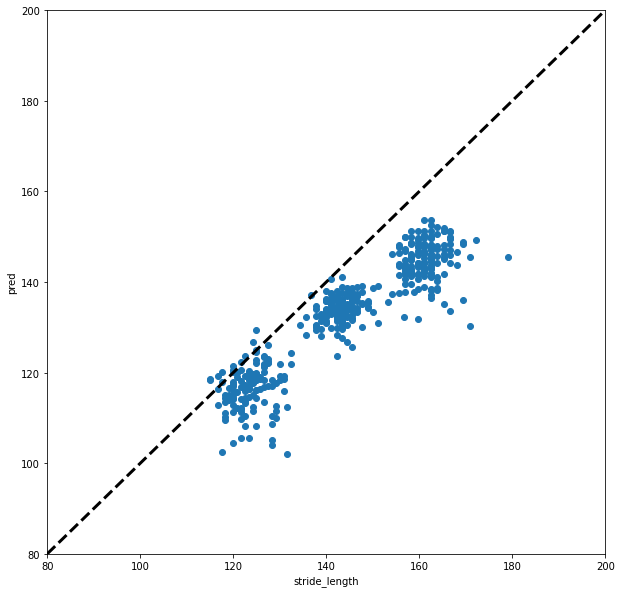

In [21]:
pred = model(inputs_acc, inputs_gyr).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

# Encoder-based Model : Acc, Gyro 각각 입력, 최종 노드 3개
- 최종적으로 출력된 노드 3개를 각 축별 distance와 곱

## No bias
- Best Result : Epoch 334, Valid Loss 10.259, MAE 2.099, Corr 0.982198

### 데이터 불러오기 

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Salted(file_path, bias=False)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [23]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

### Model & Scatter Plot
- Best Result : Epoch 259, Valid Loss 40.381912, MAE 4.223338

In [24]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder_dist(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder_dist, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(7744*2, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 3)
        )
        

    def forward(self, inputs_acc, inputs_gyr, inputs_pst): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        enc_output = torch.concat((conv1d_output_acc, conv1d_output_gyr), 1)
        dense_output = self.dense(enc_output)
        output = torch.unsqueeze(torch.sum(dense_output*inputs_pst, axis=1), 1)

        
        return output

In [25]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder_dist(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [26]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_corr = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, inputs_pst = data
        inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
        inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr, inputs_pst)

        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()
        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, inputs_pst = data
            inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
            inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr, inputs_pst)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    corr = torch.corrcoef(torch.stack([torch.squeeze(stride_length), torch.squeeze(outputs)]))[0, 1]
    
    
    print("Epoch : {}/{}, Train Loss : {:.3f}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE, corr))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_corr = corr
        best_epoch = epoch+1
        torch.save(model.state_dict(), './model/encoder_dist_best_ks30_nobias.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}'.format(best_epoch, best, best_MAE, best_corr))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 7290.432, Valid Loss 228.996, MAE 10.242, Corr 0.756566
Best Valid Loss 228.9962
Epoch : 2/2000, Train Loss : 651.847, Valid Loss 423.297, MAE 14.514, Corr 0.769077
Epoch : 3/2000, Train Loss : 257.047, Valid Loss 176.653, MAE 9.652, Corr 0.777479
Best Valid Loss 176.6525
Epoch : 4/2000, Train Loss : 184.053, Valid Loss 161.712, MAE 9.600, Corr 0.780162
Best Valid Loss 161.7124
Epoch : 5/2000, Train Loss : 168.569, Valid Loss 164.148, MAE 9.042, Corr 0.778145
Epoch : 6/2000, Train Loss : 160.000, Valid Loss 149.112, MAE 9.385, Corr 0.778511
Best Valid Loss 149.1118
Epoch : 7/2000, Train Loss : 153.506, Valid Loss 146.968, MAE 8.973, Corr 0.779062
Best Valid Loss 146.9676
Epoch : 8/2000, Train Loss : 153.228, Valid Loss 145.530, MAE 9.119, Corr 0.780399
Best Valid Loss 145.5302
Epoch : 9/2000, Train Loss : 151.906, Valid Loss 153.170, MAE 9.953, Corr 0.783731
Epoch : 10/2000, Train Loss : 150.557, Valid Loss 144.967, MAE 9.199, Corr 0.789345
Best Valid Loss 

Epoch : 90/2000, Train Loss : 119.543, Valid Loss 109.588, MAE 7.110, Corr 0.885624
Epoch : 91/2000, Train Loss : 115.995, Valid Loss 108.629, MAE 7.152, Corr 0.880827
Best Valid Loss 108.6291
Epoch : 92/2000, Train Loss : 109.798, Valid Loss 113.980, MAE 8.064, Corr 0.877147
Epoch : 93/2000, Train Loss : 114.039, Valid Loss 113.824, MAE 6.653, Corr 0.882317
Epoch : 94/2000, Train Loss : 110.293, Valid Loss 122.903, MAE 6.851, Corr 0.884335
Epoch : 95/2000, Train Loss : 112.472, Valid Loss 108.153, MAE 7.382, Corr 0.875594
Best Valid Loss 108.1528
Epoch : 96/2000, Train Loss : 110.870, Valid Loss 137.333, MAE 9.916, Corr 0.880275
Epoch : 97/2000, Train Loss : 113.984, Valid Loss 104.410, MAE 6.890, Corr 0.888513
Best Valid Loss 104.4099
Epoch : 98/2000, Train Loss : 108.153, Valid Loss 103.470, MAE 6.654, Corr 0.886397
Best Valid Loss 103.4700
Epoch : 99/2000, Train Loss : 157.136, Valid Loss 111.371, MAE 8.032, Corr 0.880687
Epoch : 100/2000, Train Loss : 119.072, Valid Loss 111.618, 

Epoch : 180/2000, Train Loss : 26.104, Valid Loss 26.047, MAE 4.447, Corr 0.938407
Best Valid Loss 26.0475
Epoch : 181/2000, Train Loss : 24.496, Valid Loss 28.879, MAE 4.550, Corr 0.941843
Epoch : 182/2000, Train Loss : 28.271, Valid Loss 29.828, MAE 4.879, Corr 0.938549
Epoch : 183/2000, Train Loss : 40.072, Valid Loss 59.159, MAE 7.585, Corr 0.948008
Epoch : 184/2000, Train Loss : 32.117, Valid Loss 49.108, MAE 6.021, Corr 0.928863
Epoch : 185/2000, Train Loss : 34.733, Valid Loss 28.083, MAE 4.687, Corr 0.938581
Epoch : 186/2000, Train Loss : 23.734, Valid Loss 24.187, MAE 4.112, Corr 0.947669
Best Valid Loss 24.1868
Epoch : 187/2000, Train Loss : 26.863, Valid Loss 24.101, MAE 4.205, Corr 0.951953
Best Valid Loss 24.1014
Epoch : 188/2000, Train Loss : 27.107, Valid Loss 41.491, MAE 5.472, Corr 0.938376
Epoch : 189/2000, Train Loss : 31.012, Valid Loss 57.254, MAE 5.829, Corr 0.942979
Epoch : 190/2000, Train Loss : 35.734, Valid Loss 35.079, MAE 5.795, Corr 0.940379
Epoch : 191/200

Epoch : 273/2000, Train Loss : 13.600, Valid Loss 12.166, MAE 2.391, Corr 0.980441
Best Valid Loss 12.1660
Epoch : 274/2000, Train Loss : 13.654, Valid Loss 11.972, MAE 2.441, Corr 0.977397
Best Valid Loss 11.9719
Epoch : 275/2000, Train Loss : 13.092, Valid Loss 17.377, MAE 3.492, Corr 0.971406
Epoch : 276/2000, Train Loss : 14.531, Valid Loss 26.785, MAE 4.028, Corr 0.981132
Epoch : 277/2000, Train Loss : 14.886, Valid Loss 20.743, MAE 3.851, Corr 0.978229
Epoch : 278/2000, Train Loss : 21.410, Valid Loss 18.495, MAE 3.681, Corr 0.962710
Epoch : 279/2000, Train Loss : 17.917, Valid Loss 16.886, MAE 3.666, Corr 0.977400
Epoch : 280/2000, Train Loss : 17.156, Valid Loss 18.938, MAE 3.478, Corr 0.978382
Epoch : 281/2000, Train Loss : 24.496, Valid Loss 49.208, MAE 7.126, Corr 0.977720
Epoch : 282/2000, Train Loss : 19.535, Valid Loss 12.023, MAE 2.664, Corr 0.977823
Epoch : 283/2000, Train Loss : 13.385, Valid Loss 13.016, MAE 2.659, Corr 0.977065
Epoch : 284/2000, Train Loss : 12.906, 

In [27]:
# scatter plot

file_path = "D:\gait_dataset/salted/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_pst = get_position_salted(file_path, distance=True)
inputs_acc, inputs_gyr, stride_length, inputs_pst = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length)), torch.Tensor(np.array(inputs_pst))
inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)

In [28]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder_dist(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./model/encoder_dist_best_ks30_nobias.pth'))
model.eval()

Encoder_dist(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=15488, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=3, bias=True)
  )
)

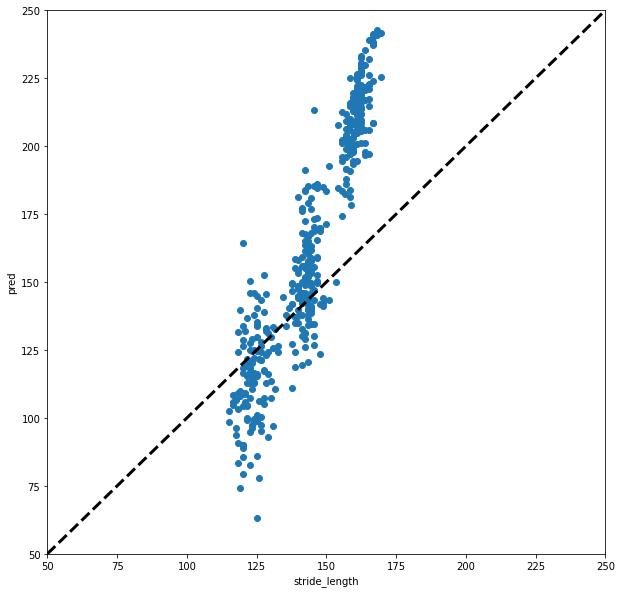

In [30]:
pred = model(inputs_acc, inputs_gyr, inputs_pst).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([50, 250])
plt.xlabel('stride_length')
plt.ylim([50, 250])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

## Bias
- Best Result : Epoch 198, Valid Loss 44.467, MAE 4.120, Corr 0.934502

### 데이터 불러오기 

In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Salted(file_path, bias=True)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [38]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

### Model & Scatter Plot

In [39]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder_dist(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder_dist, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(7744*2, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 3)
        )
        

    def forward(self, inputs_acc, inputs_gyr, inputs_pst): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        enc_output = torch.concat((conv1d_output_acc, conv1d_output_gyr), 1)
        dense_output = self.dense(enc_output)
        output = torch.unsqueeze(torch.sum(dense_output*inputs_pst, axis=1), 1)

        
        return output

In [40]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder_dist(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [41]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_corr = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, inputs_pst = data
        inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
        inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr, inputs_pst)

        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()
        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, inputs_pst = data
            inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
            inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr, inputs_pst)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    corr = torch.corrcoef(torch.stack([torch.squeeze(stride_length), torch.squeeze(outputs)]))[0, 1]
    
    
    print("Epoch : {}/{}, Train Loss : {:.3f}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE, corr))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_corr = corr
        best_epoch = epoch+1
        torch.save(model.state_dict(), './model/encoder_dist_best_ks30_bias.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}'.format(best_epoch, best, best_MAE, best_corr))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 7235.113, Valid Loss 819.663, MAE 24.851, Corr 0.346010
Best Valid Loss 819.6633
Epoch : 2/2000, Train Loss : 968.126, Valid Loss 732.959, MAE 21.096, Corr 0.355836
Best Valid Loss 732.9586
Epoch : 3/2000, Train Loss : 583.519, Valid Loss 529.772, MAE 18.206, Corr 0.362734
Best Valid Loss 529.7723
Epoch : 4/2000, Train Loss : 527.479, Valid Loss 518.005, MAE 18.006, Corr 0.369561
Best Valid Loss 518.0050
Epoch : 5/2000, Train Loss : 512.825, Valid Loss 502.292, MAE 17.495, Corr 0.378289
Best Valid Loss 502.2919
Epoch : 6/2000, Train Loss : 505.108, Valid Loss 486.128, MAE 16.978, Corr 0.388988
Best Valid Loss 486.1276
Epoch : 7/2000, Train Loss : 491.015, Valid Loss 495.905, MAE 16.686, Corr 0.402418
Epoch : 8/2000, Train Loss : 485.808, Valid Loss 458.937, MAE 15.999, Corr 0.415465
Best Valid Loss 458.9366
Epoch : 9/2000, Train Loss : 468.864, Valid Loss 436.389, MAE 15.435, Corr 0.435053
Best Valid Loss 436.3885
Epoch : 10/2000, Train Loss : 443.719, Vali

Epoch : 86/2000, Train Loss : 117.467, Valid Loss 121.238, MAE 7.554, Corr 0.843704
Epoch : 87/2000, Train Loss : 110.934, Valid Loss 120.317, MAE 7.871, Corr 0.852810
Best Valid Loss 120.3169
Epoch : 88/2000, Train Loss : 116.285, Valid Loss 118.119, MAE 7.591, Corr 0.846782
Best Valid Loss 118.1193
Epoch : 89/2000, Train Loss : 113.403, Valid Loss 121.730, MAE 7.464, Corr 0.848160
Epoch : 90/2000, Train Loss : 105.846, Valid Loss 123.414, MAE 8.009, Corr 0.856002
Epoch : 91/2000, Train Loss : 111.004, Valid Loss 162.568, MAE 9.096, Corr 0.848266
Epoch : 92/2000, Train Loss : 121.624, Valid Loss 155.365, MAE 9.807, Corr 0.857851
Epoch : 93/2000, Train Loss : 118.457, Valid Loss 116.934, MAE 7.563, Corr 0.853222
Best Valid Loss 116.9338
Epoch : 94/2000, Train Loss : 147.328, Valid Loss 118.139, MAE 7.841, Corr 0.849443
Epoch : 95/2000, Train Loss : 135.452, Valid Loss 160.314, MAE 9.817, Corr 0.845497
Epoch : 96/2000, Train Loss : 116.026, Valid Loss 121.090, MAE 8.154, Corr 0.854074
E

Epoch : 177/2000, Train Loss : 46.615, Valid Loss 53.721, MAE 4.495, Corr 0.914302
Epoch : 178/2000, Train Loss : 58.938, Valid Loss 72.439, MAE 5.755, Corr 0.906298
Epoch : 179/2000, Train Loss : 49.255, Valid Loss 66.178, MAE 6.855, Corr 0.918575
Epoch : 180/2000, Train Loss : 51.642, Valid Loss 93.507, MAE 6.650, Corr 0.911385
Epoch : 181/2000, Train Loss : 61.967, Valid Loss 58.808, MAE 4.971, Corr 0.914563
Epoch : 182/2000, Train Loss : 49.435, Valid Loss 72.553, MAE 5.190, Corr 0.925906
Epoch : 183/2000, Train Loss : 44.028, Valid Loss 71.947, MAE 7.454, Corr 0.921304
Epoch : 184/2000, Train Loss : 51.282, Valid Loss 63.219, MAE 6.435, Corr 0.925236
Epoch : 185/2000, Train Loss : 52.967, Valid Loss 50.446, MAE 4.366, Corr 0.920286
Best Valid Loss 50.4459
Epoch : 186/2000, Train Loss : 54.468, Valid Loss 95.794, MAE 9.061, Corr 0.927483
Epoch : 187/2000, Train Loss : 43.002, Valid Loss 54.053, MAE 4.597, Corr 0.924779
Epoch : 188/2000, Train Loss : 45.183, Valid Loss 50.586, MAE 4

In [42]:
# scatter plot

file_path = "D:\gait_dataset/salted/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_pst = get_position_salted(file_path, distance=True)
inputs_acc, inputs_gyr, stride_length, inputs_pst = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length)), torch.Tensor(np.array(inputs_pst))
inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)

In [43]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder_dist(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./model/encoder_dist_best_ks30_bias.pth'))
model.eval()

Encoder_dist(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=15488, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=3, bias=True)
  )
)

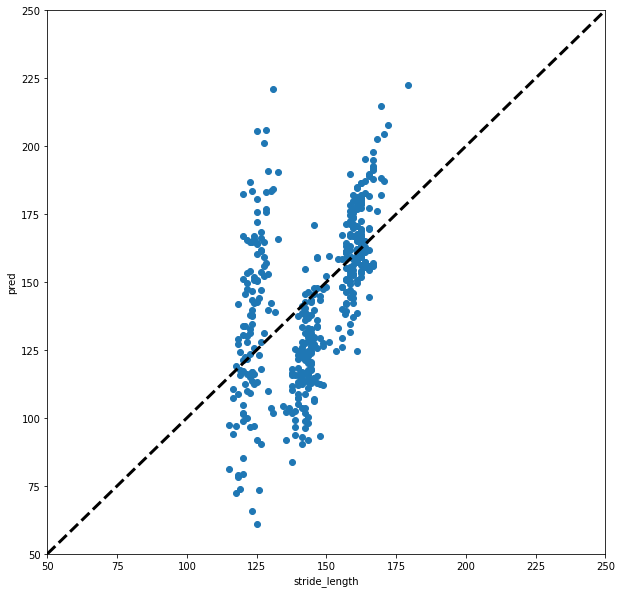

In [44]:
pred = model(inputs_acc, inputs_gyr, inputs_pst).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([50, 250])
plt.xlabel('stride_length')
plt.ylim([50, 250])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()